# Purpose
This notebooks builds a global and local discriminator model.

# Import

In [1]:
import pandas as pd
import torch

from glic.networks.discriminators import *
from glic.utils import *

# Discriminators

## Global discriminator

In [2]:
gd_layers_params = pd.read_pickle("../lib/glic/networks/gd_layers_params.p")
gd_layers_params

,type,kernel,dilatation,stride,inputs,outputs,batchnorm,activation
0,conv,5,1,2,3,64,True,ReLU
1,conv,5,1,2,64,128,True,ReLU
2,conv,5,1,2,128,256,True,ReLU
3,conv,5,1,2,256,512,True,ReLU
4,conv,5,1,2,512,512,True,ReLU
5,conv,5,1,2,512,512,True,ReLU


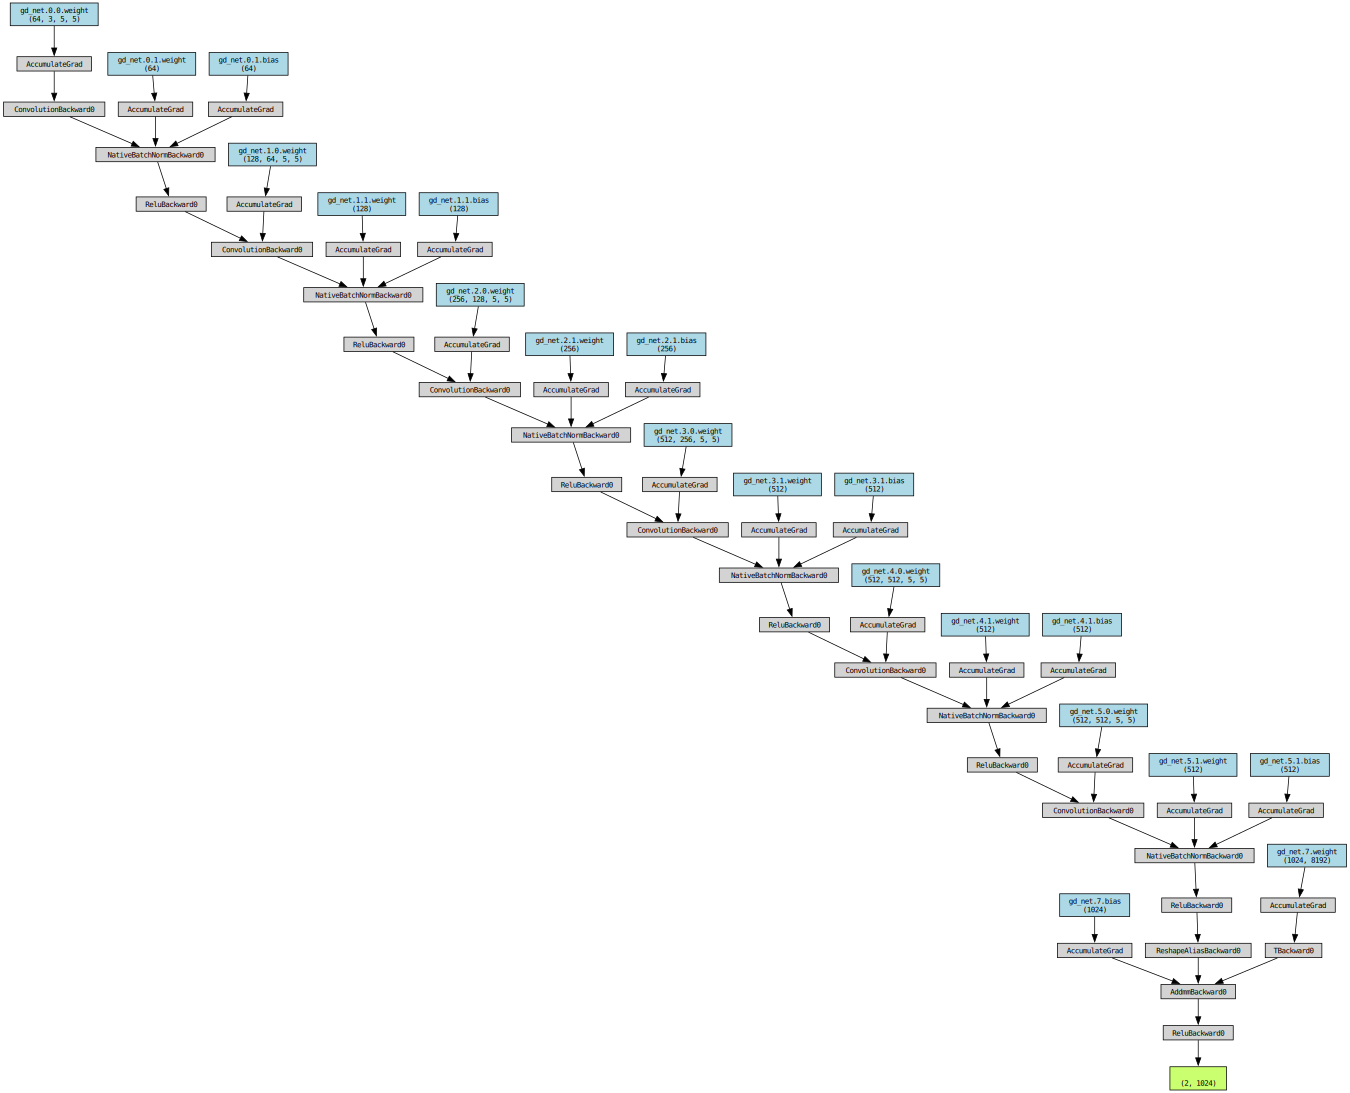

In [3]:
gd = GlobalDiscriminator()
x = torch.randn(2, 3, 256, 256)
y = gd(x)
from torchviz import make_dot
make_dot(y, params=dict(gd.named_parameters()))

## Local discriminator

In [4]:
ld_layers_params = pd.read_pickle("../lib/glic/networks/ld_layers_params.p")
ld_layers_params

,type,kernel,dilatation,stride,inputs,outputs,batchnorm,activation
0,conv,5,1,2,3,64,True,ReLU
1,conv,5,1,2,64,128,True,ReLU
2,conv,5,1,2,128,256,True,ReLU
3,conv,5,1,2,256,512,True,ReLU
4,conv,5,1,2,512,512,True,ReLU


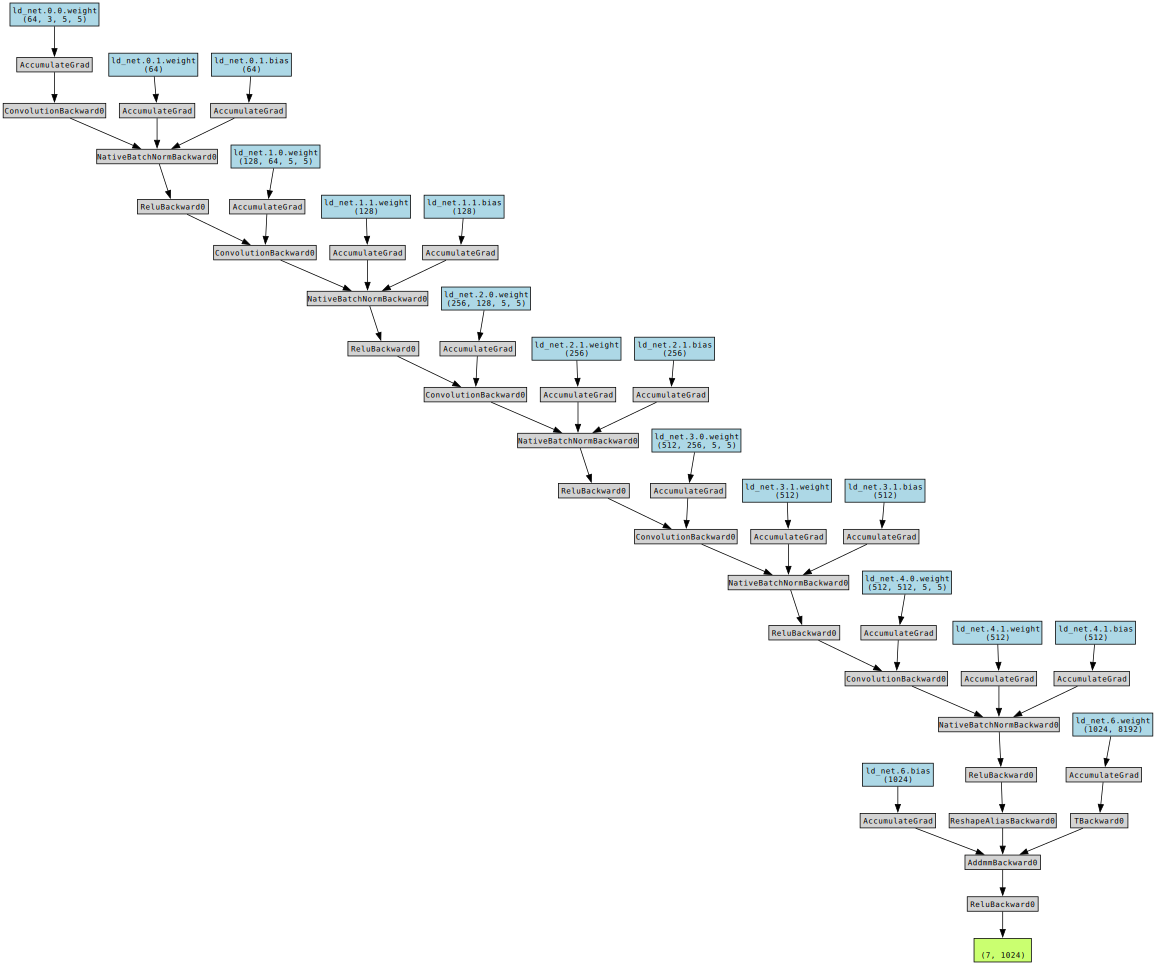

In [5]:
ld = LocalDiscriminator()
local_x = torch.randn(7, 3, 128, 128)
y = ld(local_x)
from torchviz import make_dot
make_dot(y, params=dict(ld.named_parameters()))

# Save and load

In [6]:
ld.save("../logs/ld/ld")
gd.save("../logs/gd/gd")

Save: state_dict saved in ../logs/ld/ld
Save: state_dict saved in ../logs/gd/gd


In [7]:
ld.load("../logs/ld/ld")
gd.load("../logs/gd/gd")

Load: load_state dict from ../logs/ld/ld
Load: load_state dict from ../logs/gd/gd


# Full discriminators

In [8]:
# load the dataset
batch_size = 4
train_dataset_dir = '../data/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_dir, transform=torchvision.transforms.ToTensor())
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# first batch
batch = next(iter(train_dataloader))[0]
lm,em = generate_mask(batch_size)
replacement_val = torch.rand(3)
masked_batch = apply_mask(batch,em,replacement_val)

In [9]:
# full discriminator
discriminator = Discriminator()
prediction = discriminator(masked_batch,lm)

# Training

In [10]:
from glic.training.discriminator_training import train_discriminator

In [11]:
# set up
cn = CompletionNetwork()
optimizer = torch.optim.Adadelta(cn.parameters(), lr=2e-4)
num_batch = 10
replacement_val = torch.rand(3)

In [16]:
# debug
iterator = iter(train_dataloader)
compute_cross_entropy_loss = torch.nn.CrossEntropyLoss()
is_cuda = False

# one batch
initial_batch = next(iterator)[0]
# mask
mask_localizations, mask = generate_mask(batch_size, is_cuda=is_cuda)
masked_batch = apply_mask(initial_batch, mask, replacement_val)
# forward + backward (completed images)
masked_batch = cn.forward(masked_batch)
preds = discriminator(masked_batch, mask_localizations)
loss = compute_cross_entropy_loss(preds, torch.ones_like(preds))
loss.backward()

In [34]:
# debug
compute_cross_entropy_loss = torch.nn.functional.cross_entropy
compute_cross_entropy_loss(preds, torch.ones_like(preds))

tensor(-0., grad_fn=<DivBackward1>)

In [12]:
# train
train_discriminator(discriminator, cn,
    optimizer,train_dataloader,
    num_batch, replacement_val)


### BATCH 1/10 ###
loss: -0.0 for non-completed images, -0.0 for completed images

### BATCH 2/10 ###
loss: -0.0 for non-completed images, -0.0 for completed images

### BATCH 3/10 ###


KeyboardInterrupt: 